<a href="https://colab.research.google.com/github/ksennon/Lab1_DA_KKA/blob/main/DA_Lab_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DCGAN генерація одягу

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Conv2DTranspose,BatchNormalization,Reshape
from tensorflow.keras import Sequential

from IPython import display

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


####Функція візуалізації згенерованих зображень

In [3]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

####Завантаження даних та переобробка

In [4]:
(X_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()
# normalize pixel values
X_train = X_train.astype(np.float32) / 255
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.   # values between -1 and +1

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
BATCH_SIZE = 128
dataset=tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(BATCH_SIZE,drop_remainder=True).prefetch(1)

###Генератор

In [6]:
codings_size = 32
generator=Sequential(
[
    Dense(7*7*128,input_shape=[codings_size]),
    Reshape([7,7,128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",activation="selu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",activation="tanh"),

])
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

###Дискримінатор

In [7]:
discriminator=Sequential([
    Conv2D(64,kernel_size=5, strides=2, padding="SAME",activation=tf.keras.layers.LeakyReLU(0.2),input_shape=[28, 28, 1]),
    tf.keras.layers.Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="SAME",activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [8]:
gan = Sequential([generator, discriminator])

###Компіляція та навчання моделі

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [12]:
def train_gan(gan,train_dataset,random_normal_dimensions,n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for img in dataset:
            batch_size=img.shape[0]
            #Phase 1
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_img = generator(noise)
            mixed_images = tf.concat([fake_img,img], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            #Phase 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)
        plot_results(fake_img, 16)
        plt.show()

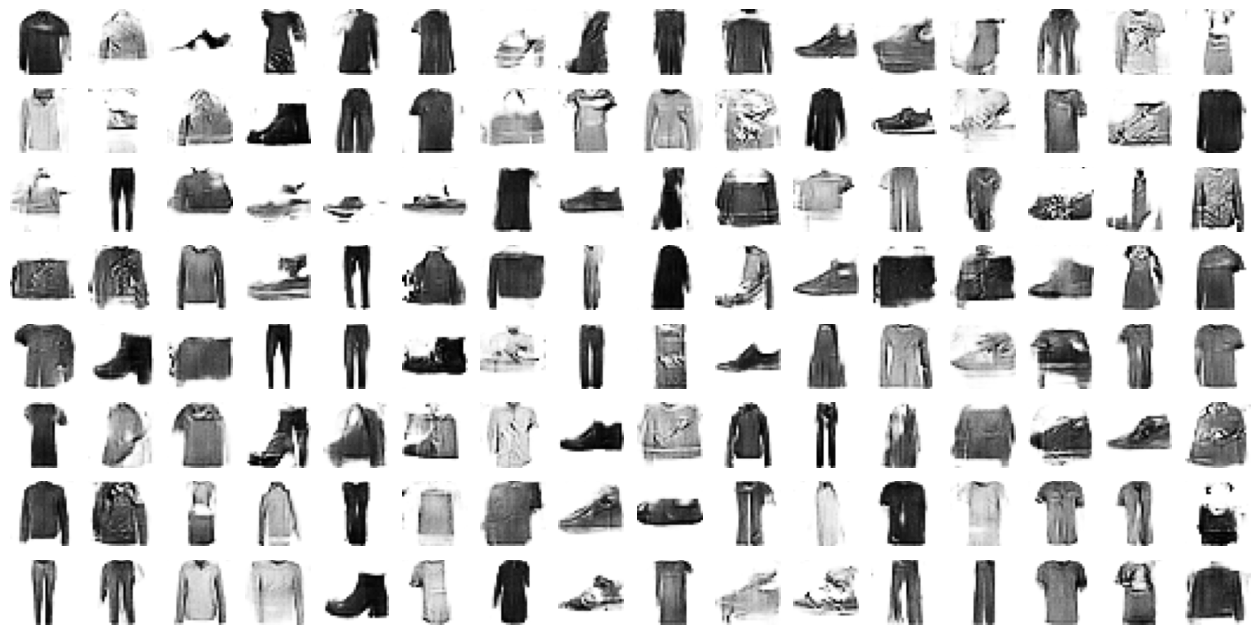

In [17]:

train_gan(gan, dataset, codings_size, 10)
